# Numbers with uncertainties

The result of a measurement should be given as a number with an attached uncertainties, besides the physical unit, and all operations performed involving the result of the measurement should propagate the uncertainty, taking care of correlation between quantities.

There is a Julia package for dealing with numbers with uncertainties: [`Measurements.jl`](https://github.com/JuliaPhysics/Measurements.jl).  Thanks to Julia's features, `DifferentialEquations.jl` easily works together with `Measurements.jl` out-of-the-box.

This notebook will cover some of the examples from the tutorial about classical Physics.

## Caveat about `Measurement` type

Before going on with the tutorial, we must point up a subtlety of `Measurements.jl` that you should be aware of:

In [1]:
using Measurements

5.23 ± 0.14 === 5.23 ± 0.14

false

In [2]:
(5.23± 0.14) - (5.23 ± 0.14)

0.0 ± 0.19798989873223333

In [3]:
(5.23 ± 0.14) / (5.23 ± 0.14)

1.0 ± 0.0378565771954557

The two numbers above, even though have the same nominal value and the same uncertainties, are actually two different measurements that only by chance share the same figures and their difference and their ratio have a non-zero uncertainty.  It is common in physics to get very similar, or even equal, results for a repeated measurement, but the two measurements are not the same thing.  

Instead, if you have *one measurement* and want to perform some operations involving it, you have to assign it to a variable:

In [4]:
x = 5.23 ± 0.14
x === x

true

In [5]:
x - x

0.0 ± 0.0

In [6]:
x / x

1.0 ± 0.0

## Radioactive Decay of Carbon-14

The rate of decay of carbon-14 is governed by a first order linear ordinary differential equation

$$ \frac{\mathrm{d}u(t)}{\mathrm{d}t} = -\frac{u(t)}{\tau} $$

where $\tau$ is the mean lifetime of carbon-14, which is related to the half-life $t_{1/2} = (5730 \pm 40)$ years by the relation $\tau = t_{1/2}/\ln(2)$.

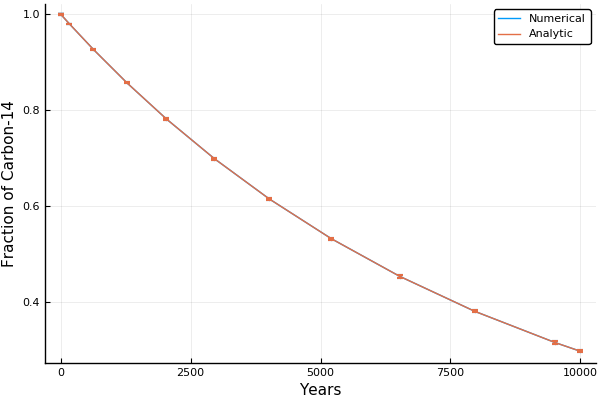

In [7]:
using DifferentialEquations, Measurements, Plots

pyplot()

# Half-life and mean lifetime of radiocarbon, in years
t_12 = 5730 ± 40
τ = t_12 / log(2)

#Setup
u₀ = 1 ± 0
tspan = (0.0, 10000.0)

#Define the problem
radioactivedecay(u,p,t) = - u / τ

#Pass to solver
prob = ODEProblem(radioactivedecay, u₀, tspan)
sol = solve(prob, Tsit5(), reltol = 1e-8)

# Analytic solution
u = exp.(- sol.t / τ)

plot(sol.t, sol.u, label = "Numerical", xlabel = "Years", ylabel = "Fraction of Carbon-14")
plot!(sol.t, u, label = "Analytic")

The two curves are perfectly superimposed, indicating that the numerical solution matches the analytic one.  We can check that also the uncertainties are correctly propagated in the numerical solution:

In [8]:
println("Quantity of carbon-14 after ",  sol.t[11], " years:")
println("Numerical: ", sol[11])
println("Analytic:  ", u[11])

Quantity of carbon-14 after 5207.5228514026385 years:
Numerical: 0.5326215661145899 ± 0.0023422116367677525
Analytic:  0.5326215654338256 ± 0.002342211664674973


Both the value of the numerical solution and its uncertainty match the analytic solution within the requested tolerance.  We can also note that close to 5730 years after the beginning of the decay (half-life of the radioisotope), the fraction of carbon-14 that survived is about 0.5.

## Simple pendulum

### Small angles approximation

The next problem we are going to study is the simple pendulum in the approximation of small angles.  We address this simplified case because there exists an easy analytic solution to compare.

The differential equation we want to solve is

$$ \ddot{\theta} + \frac{g}{L} \theta = 0 $$

where $g = (9.79 \pm 0.02)~\mathrm{m}/\mathrm{s}^2$ is the gravitational acceleration measured where the experiment is carried out, and $L = (1.00 \pm 0.01)~\mathrm{m}$ is the length of the pendulum.

When you set up the problem for `DifferentialEquations.jl` remember to define the measurements as variables, as seen above.

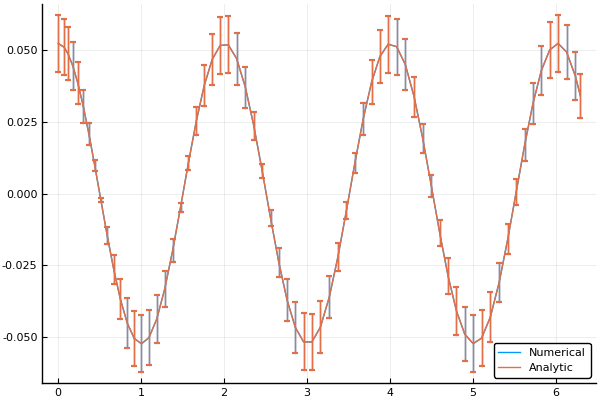

In [9]:
using DifferentialEquations, Measurements, Plots

pyplot()

g = 9.79 ± 0.02; # Gravitational constants
L = 1.00 ± 0.01; # Length of the pendulum

#Initial Conditions
u₀ = [0 ± 0, π / 60 ± 0.01] # Initial speed and initial angle
tspan = (0.0, 6.3)

#Define the problem
function simplependulum(du,u,p,t)
    θ  = u[1]
    dθ = u[2]
    du[1] = dθ
    du[2] = -(g/L)*θ
end

#Pass to solvers
prob = ODEProblem(simplependulum, u₀, tspan)
sol = solve(prob, Tsit5(), reltol = 1e-6)

# Analytic solution
u = u₀[2] .* cos.(sqrt(g / L) .* sol.t)

plot(sol.t, getindex.(sol.u, 2), label = "Numerical")
plot!(sol.t, u, label = "Analytic")

Also in this case there is a perfect superimposition between the two curves, including their uncertainties.

We can also have a look at the difference between the two solutions:

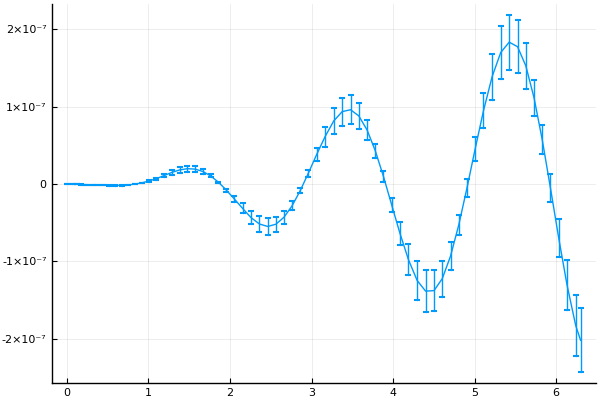

In [10]:
plot(sol.t, getindex.(sol.u, 2) .- u, label = "")

## Arbitrary amplitude

Now that we know how to solve differential equations involving numbers with uncertainties we can solve the simple pendulum problem without any approximation.  This time the differential equation to solve is the following:

$$ \ddot{\theta} + \frac{g}{L} \sin(\theta) = 0 $$

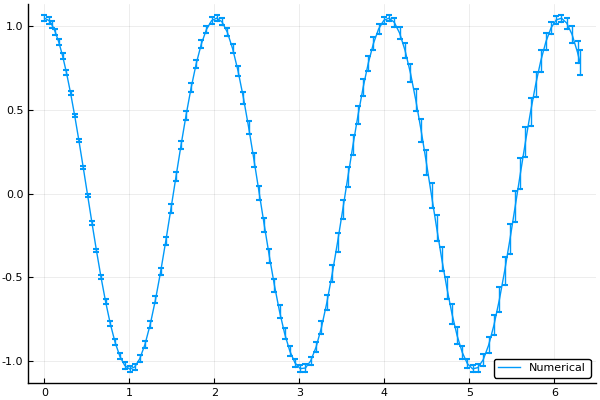

In [11]:
using DifferentialEquations, Measurements, Plots

pyplot()

g = 9.79 ± 0.02; # Gravitational constants
L = 1.00 ± 0.01; # Length of the pendulum

#Initial Conditions
u₀ = [0 ± 0, π / 3 ± 0.02] # Initial speed and initial angle
tspan = (0.0, 6.3)

#Define the problem
function simplependulum(du,u,p,t)
    θ  = u[1]
    dθ = u[2]
    du[1] = dθ
    du[2] = -(g/L) * sin(θ)
end

#Pass to solvers
prob = ODEProblem(simplependulum, u₀, tspan)
sol = solve(prob, Tsit5(), reltol = 1e-6)

plot(sol.t, getindex.(sol.u, 2), label = "Numerical")

We note that in this case the period of the oscillations is not constant.